In [3]:
import warnings
from tqdm import TqdmWarning
warnings.filterwarnings("ignore", category=TqdmWarning)

import pandas as pd
import numpy as np
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict, Counter

import simulation.world_cup_simulation as wc

# Paths
BASE_DIR = os.path.dirname(os.getcwd())
RESULTS_5Y_CSV = "data/processed/results_last_5yrs.csv"
RESULTS_10Y_CSV = "data/processed/results_last_10yrs.csv"
TEAM_STRENGTH_CSV = "data/derived/team_strengths_weighted_median.csv"

# Load match data
df = pd.read_csv(os.path.join(BASE_DIR, RESULTS_10Y_CSV))
df["date"] = pd.to_datetime(df["date"])

# Load team strength CSV (scaled 0-1)
team_strength_df = pd.read_csv(os.path.join(BASE_DIR, TEAM_STRENGTH_CSV))
if team_strength_df.columns[0] != "team":
    team_strength_df = team_strength_df.rename(columns={team_strength_df.columns[0]: "team"})

# Create attack/defense priors as dicts
attack_prior = team_strength_df.set_index("team")["attack_strength"].to_dict()
defense_prior = team_strength_df.set_index("team")["defense_strength"].to_dict()

# Map teams to indices for Pyro
teams = pd.unique(df[["home_team", "away_team"]].values.ravel())
team_to_idx = {team: i for i, team in enumerate(teams)}
idx_to_team = {i: team for team, i in team_to_idx.items()}
n_teams = len(teams)

# Prepare tensors for Pyro
home_idx = torch.tensor([team_to_idx[t.lower()] for t in df["home_team"]], dtype=torch.long)
away_idx = torch.tensor([team_to_idx[t.lower()] for t in df["away_team"]], dtype=torch.long)
home_goals = torch.tensor(df["home_score"].values, dtype=torch.float)
away_goals = torch.tensor(df["away_score"].values, dtype=torch.float)
home_adv_indicator = torch.tensor((~df["neutral"]).astype(int).values, dtype=torch.float)


In [4]:
def attack_defense_model(home_idx, away_idx, home_goals, away_goals, home_adv_indicator):
    # Team-level latent variables
    attack = pyro.sample("attack", dist.Normal(0., 1.).expand([n_teams]).to_event(1))
    defense = pyro.sample("defense", dist.Normal(0., 1.).expand([n_teams]).to_event(1))

    # Global parameters
    alpha = pyro.sample("alpha", dist.Normal(0., 1.))
    home_adv = pyro.sample("home_adv", dist.Normal(0., 0.5))

    # Expected goals
    lambda_home = torch.exp(alpha + attack[home_idx] - defense[away_idx] + home_adv * home_adv_indicator)
    lambda_away = torch.exp(alpha + attack[away_idx] - defense[home_idx])

    with pyro.plate("matches", len(home_idx)):
        pyro.sample("obs_home", dist.Poisson(lambda_home), obs=home_goals)
        pyro.sample("obs_away", dist.Poisson(lambda_away), obs=away_goals)

In [5]:
nuts_kernel = NUTS(attack_defense_model)
mcmc = MCMC(
    nuts_kernel,
    num_samples=800,
    warmup_steps=300,
    num_chains=1
)

mcmc.run(
    home_idx,
    away_idx,
    home_goals,
    away_goals,
    home_adv_indicator
)

posterior = mcmc.get_samples()


Sample: 100%|██████████| 1100/1100 [01:43, 10.61it/s, step size=1.35e-01, acc. prob=0.922]


In [6]:
# Posterior means
attack_mean = posterior["attack"].mean(dim=0).numpy()
defense_mean = posterior["defense"].mean(dim=0).numpy()
team_names = [idx_to_team[i] for i in range(n_teams)]

# Shrinkage factor
shrinkage = 0.6

# Adjust posterior toward priors (use scaled columns)
attack_adj = np.array([
    attack_mean[i] * (1 - shrinkage) + attack_prior.get(team, 0.5) * shrinkage
    for i, team in enumerate(team_names)
])
defense_adj = np.array([
    defense_mean[i] * (1 - shrinkage) + defense_prior.get(team, 0.5) * shrinkage
    for i, team in enumerate(team_names)
])

# Compute skill as weighted attack minus average defense
avg_defense = np.mean(defense_adj)
skill_adj = attack_adj - avg_defense

# Build dataframe
team_skills_df = pd.DataFrame({
    "team": team_names,
    "attack": attack_adj,
    "defense": defense_adj,
    "skill": skill_adj
})

# Only keep World Cup teams
wc_teams = [t.lower() for g in wc.groups.values() for t in g]
team_skills_df = team_skills_df[team_skills_df["team"].isin(wc_teams)]
team_skills_df = team_skills_df.sort_values("skill", ascending=False)
team_skills_df

,team,attack,defense,skill
24,spain,0.979911,0.542809,0.846010
18,norway,0.965065,0.336166,0.831163
158,argentina,0.916872,1.006586,0.782970
33,portugal,0.913184,0.513186,0.779282
107,germany,0.912299,0.430993,0.778397
23,netherlands,0.902518,0.448134,0.768616
103,france,0.896292,0.518711,0.762390
32,england,0.880432,0.984657,0.746530
85,colombia,0.857769,0.530270,0.723867
161,italy,0.815605,0.501994,0.681703


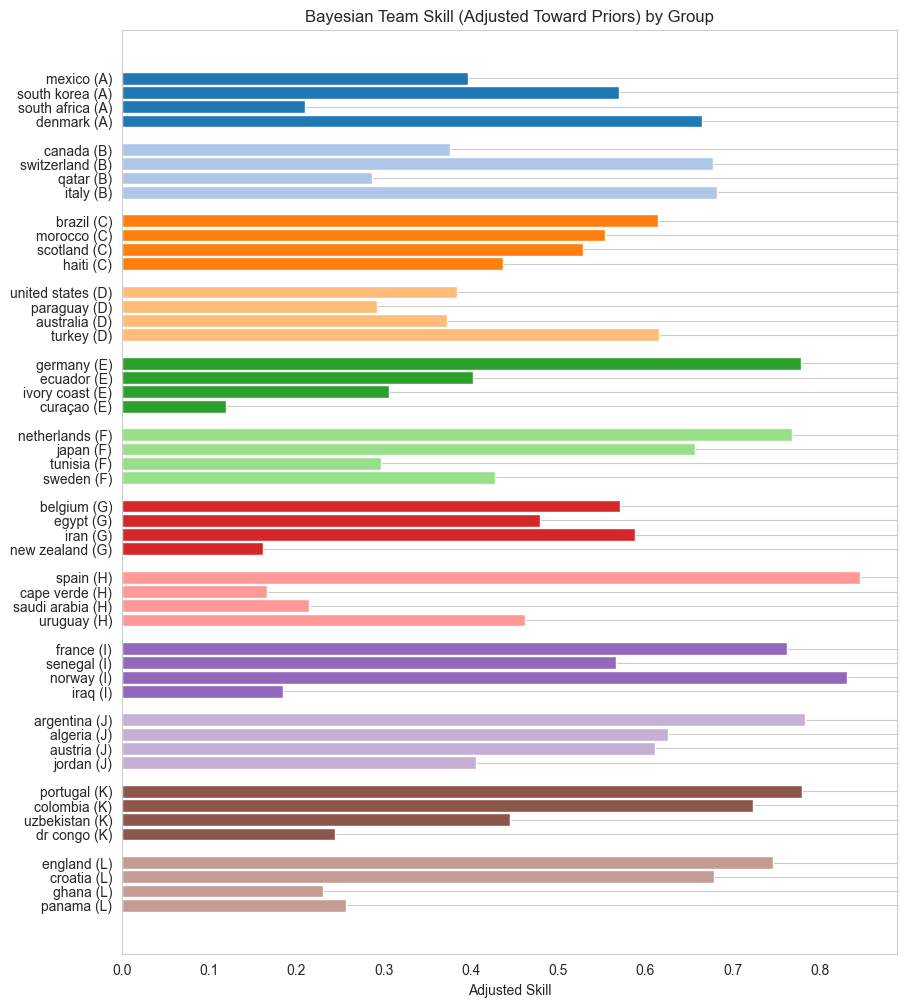

In [7]:
plot_teams, plot_skills, plot_colors, group_positions = [], [], [], []

for i, (group, group_teams) in enumerate(wc.groups.items()):
    color = plt.get_cmap("tab20")(i)
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            plot_teams.append(team)
            plot_skills.append(team_skills_df.set_index("team").loc[team_lower, "skill"])
            plot_colors.append(color)
            group_positions.append(i + j * 0.2)

plt.figure(figsize=(10, 12))
plt.barh(group_positions, plot_skills, color=plot_colors, height=0.18)

yticks, yticklabels = [], []
for i, (group, group_teams) in enumerate(wc.groups.items()):
    for j, team in enumerate(group_teams):
        team_lower = team.lower()
        if team_lower in team_skills_df["team"].values:
            yticks.append(i + j * 0.2)
            yticklabels.append(f"{team} ({group})")

plt.yticks(yticks, yticklabels)
plt.gca().invert_yaxis()
plt.xlabel("Adjusted Skill")
plt.title("Bayesian Team Skill (Adjusted Toward Priors) by Group")
plt.grid(axis="x")
plt.show()


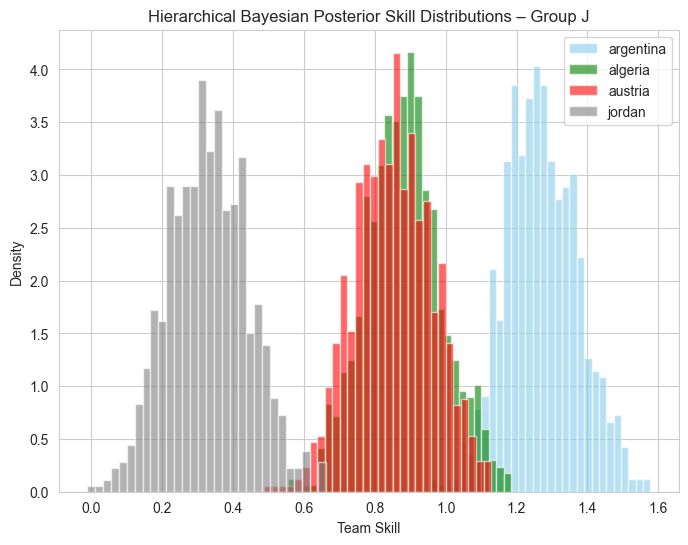

In [8]:
# Posterior distributions of team skill – Group J
group = wc.groups["J"]
colors = ["skyblue", "green", "red", "grey"]

plt.figure(figsize=(8,6))

for i, team in enumerate(group):
    team_lower = team.lower()
    if team_lower not in team_to_idx:
        continue
    idx = team_to_idx[team_lower]

    # Compute skill for each posterior sample: attack - mean(defense)
    samples = (posterior["attack"][:, idx] - posterior["defense"].mean(dim=1)).numpy()

    plt.hist(samples, bins=30, alpha=0.6, density=True,
             label=team, color=colors[i])

plt.xlabel("Team Skill")
plt.ylabel("Density")
plt.title("Hierarchical Bayesian Posterior Skill Distributions – Group J")
plt.legend()
plt.show()

In [9]:
def skill_func(team, shrinkage=0.6):
    """
    Returns the shrinkage-adjusted skill for a team based on the posterior.
    This includes posterior mean attack, shrinkage toward prior, and defense adjustment.
    """
    # Find team index
    idx = team_to_idx[team]

    # Posterior means
    attack_mean = posterior["attack"].mean(dim=0).numpy()
    defense_mean = posterior["defense"].mean(dim=0).numpy()
    team_names = [idx_to_team[i] for i in range(n_teams)]

    # Shrinkage adjustment
    attack_adj = attack_mean[idx] * (1 - shrinkage) + attack_prior.get(team, 0.5) * shrinkage
    defense_adj = defense_mean[idx] * (1 - shrinkage) + defense_prior.get(team, 0.5) * shrinkage

    # Compute average defense across all teams
    avg_defense = np.mean([
        defense_mean[i] * (1 - shrinkage) + defense_prior.get(team_names[i], 0.5) * shrinkage
        for i in range(n_teams)
    ])

    # Skill = adjusted attack minus average defense
    return attack_adj - avg_defense


In [10]:
N = 1000
all_results = defaultdict(list)

for _ in range(N):
    placements = wc.simulate_world_cup(sf=skill_func, verbose=False)
    for team, stage in placements.items():
        all_results[team].append(stage)


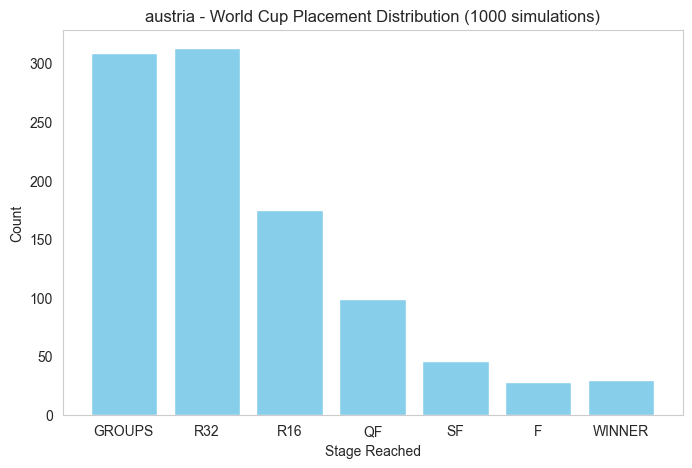

In [15]:
country = "austria"

# count placements
counts = Counter(all_results[country])

# ensure consistent order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']
counts = [counts.get(stage, 0) for stage in stages]

plt.figure(figsize=(8,5))
plt.bar(stages, counts, color='skyblue')
plt.title(country + " - World Cup Placement Distribution (" + str(N) + " simulations)")
plt.ylabel("Count")
plt.grid(False)
plt.xlabel("Stage Reached")
plt.show()

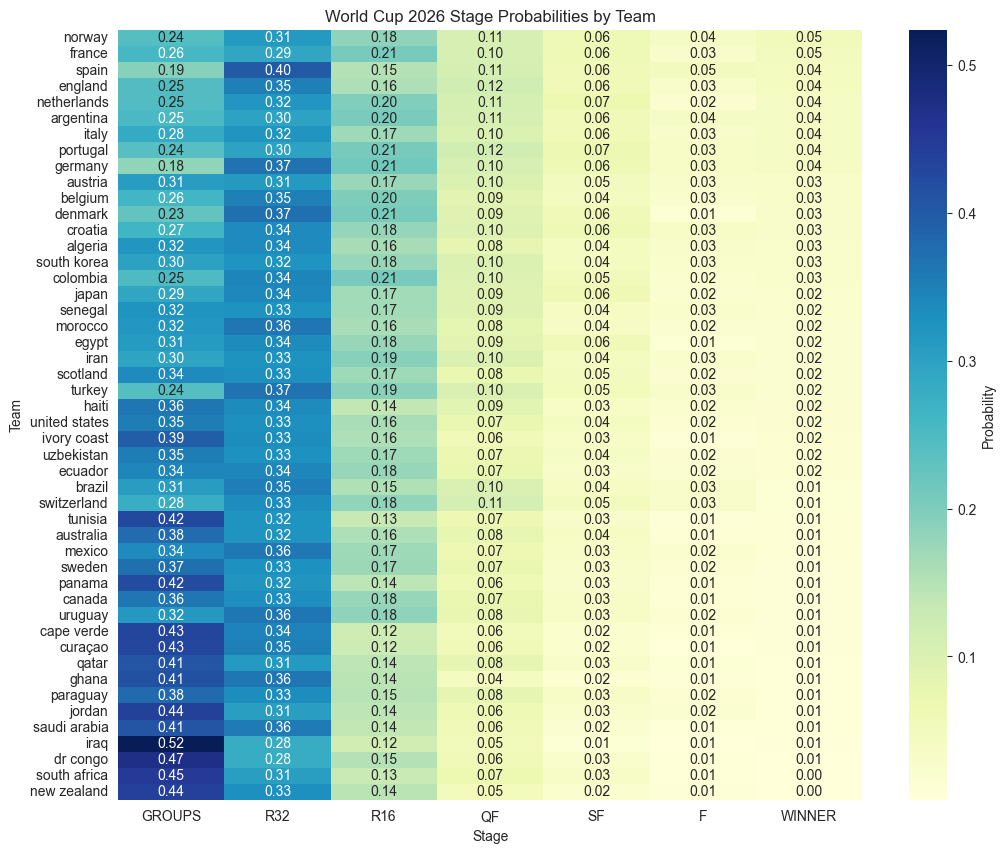

In [12]:
# Define stages in order
stages = ['GROUPS', 'R32', 'R16', 'QF', 'SF', 'F', 'WINNER']

# Compute stage probabilities for each team
team_stage_probs = {}
for team, results in all_results.items():
    counts = Counter(results)
    team_stage_probs[team] = {stage: counts.get(stage, 0)/len(results) for stage in stages}

# Convert to DataFrame
prob_df = pd.DataFrame(team_stage_probs).T  # Teams as rows
prob_df = prob_df[stages]  # Ensure correct stage order

# Sort teams by probability of reaching WINNER stage
prob_df = prob_df.sort_values("WINNER", ascending=False)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(prob_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Probability'})
plt.title("World Cup 2026 Stage Probabilities by Team")
plt.ylabel("Team")
plt.xlabel("Stage")
plt.yticks(rotation=0)
plt.show()

In [13]:
N = 1000
winners = []

for _ in range(N):
    # Draw a single posterior sample for all teams
    s = np.random.randint(len(posterior["attack"]))
    skills = {
        team: (posterior["attack"][s, team_to_idx[team]] - posterior["defense"][s].mean()).item()
        for team in wc_teams  # your filtered WC teams in lowercase
    }

    # Simulate one tournament with these skills
    placements = wc.simulate_world_cup(sf=lambda team: skills[team], verbose=False)

    # Append the winner
    for team, stage in placements.items():
        if stage == "WINNER":
            winners.append(team)

# Compute actual probabilities
winner_counts = Counter(winners)
winner_probs = {team: count / N for team, count in winner_counts.items()}

# Sort
winner_probs_sorted = dict(sorted(winner_probs.items(), key=lambda x: x[1], reverse=True))

print("World Cup 2026 Winning Probabilities (N=1000 simulations)")
print("Top 10 teams by chance of winning:\n")
print(f"{'Rank':<4} {'Team':<15} {'Probability':<10}")
print("-" * 32)

for i, (team, prob) in enumerate(list(winner_probs_sorted.items())[:10], 1):
    print(f"{i:<4} {team:<15} {prob:.3f}")

print("-" * 32)

World Cup 2026 Winning Probabilities (N=1000 simulations)
Top 10 teams by chance of winning:

Rank Team            Probability
--------------------------------
1    spain           0.088
2    germany         0.070
3    brazil          0.064
4    belgium         0.058
5    argentina       0.056
6    france          0.054
7    portugal        0.053
8    england         0.041
9    netherlands     0.041
10   colombia        0.033
--------------------------------
